In [33]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import torch.nn as nn
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

Data Preprocessing

In [35]:
train_df = pd.read_csv("./train.csv")
test_df = pd.read_csv("./test.csv")

train_df.columns, train_df.head(), test_df.columns, test_df.head()

(Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
        'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'cnt'],
       dtype='object'),
    instant      dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
 0        1  2011-01-01       1   0     1   0        0        6           0   
 1        2  2011-01-01       1   0     1   1        0        6           0   
 2        3  2011-01-01       1   0     1   2        0        6           0   
 3        4  2011-01-01       1   0     1   3        0        6           0   
 4        5  2011-01-01       1   0     1   4        0        6           0   
 
    weathersit  temp   atemp   hum  windspeed  cnt  
 0           1  0.24  0.2879  0.81        0.0   16  
 1           1  0.22  0.2727  0.80        0.0   40  
 2           1  0.22  0.2727  0.80        0.0   32  
 3           1  0.24  0.2879  0.75        0.0   13  
 4           1  0.24  0.2879  0.75        0.0    1  ,
 Index(['instant', 

(檢查資料集是否有空值)

In [36]:
print("train_df have empty values? ", train_df.isnull().sum())
print("train_df have empty values? ", test_df.isnull().sum())

train_df have empty values?  instant       0
dteday        0
season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
cnt           0
dtype: int64
train_df have empty values?  instant       0
dteday        0
season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
dtype: int64


In [37]:
# merge dteday & hr and set as index
train_df["datetime"] = pd.to_datetime(train_df["dteday"]) + pd.to_timedelta(train_df["hr"], unit="h")
test_df["datetime"] = pd.to_datetime(test_df["dteday"]) + pd.to_timedelta(test_df["hr"], unit="h")
train_df.set_index("datetime", inplace=True)
test_df.set_index("datetime", inplace=True)

# features
all_features = ['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed']
target = 'cnt'

# scaling
scaler = MinMaxScaler()
train_scaled_all = scaler.fit_transform(train_df[all_features])
test_scaled_all = scaler.transform(test_df[all_features])
target_scaler = MinMaxScaler()
target_scaled = target_scaler.fit_transform(train_df[[target]])

# convert to time series format for LSTM (sliding windows)
def create_lstm_dataset(X, y, window_size):
    Xs, ys = [], []
    for i in range(len(X) - window_size):
        Xs.append(X[i:i+window_size])
        ys.append(y[i+window_size])
    return np.array(Xs), np.array(ys)

window_size = 48
X_train, y_train = create_lstm_dataset(train_scaled_all, target_scaled, window_size)
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)

X_train shape:  (15871, 48, 12)
y_train shape:  (15871, 1)


Feature Selection

Feature Importance Ranking: 
workingday    0.283910
hr            0.230456
yr            0.184763
temp          0.101497
atemp         0.071040
season        0.040174
weathersit    0.038882
mnth          0.015570
weekday       0.011716
hum           0.010386
holiday       0.008204
windspeed     0.003402
dtype: float32


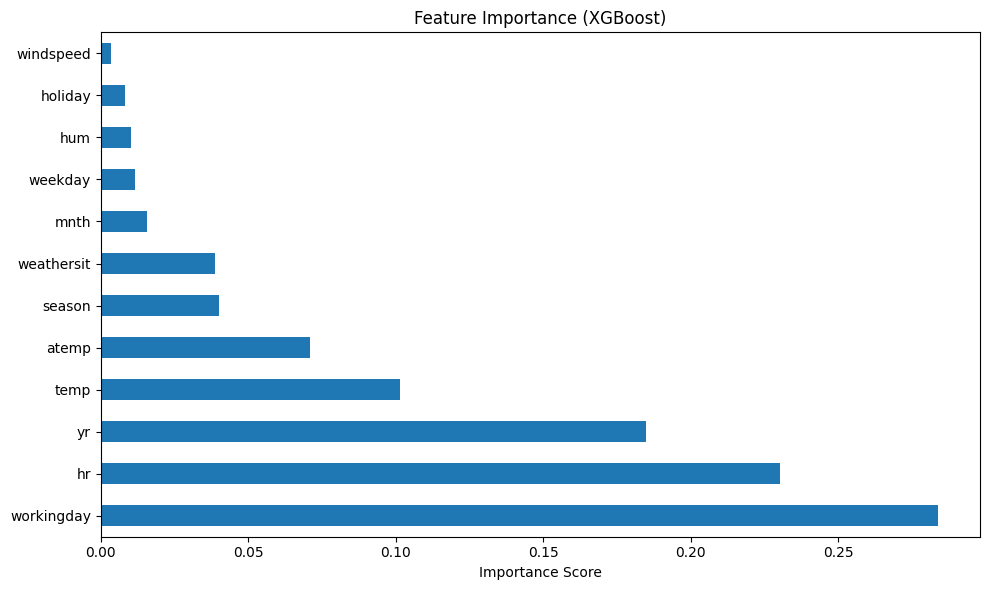

In [38]:
X_fs = train_df[all_features]
y_fs = train_df["cnt"]
X_train_fs, X_val_fs, y_train_fs, y_val_fs = train_test_split(X_fs, y_fs, test_size=0.2, random_state=42)

xgb = XGBRegressor()
xgb.fit(X_train_fs, y_train_fs)

importance = pd.Series(xgb.feature_importances_, index=X_fs.columns).sort_values(ascending=False)
print("Feature Importance Ranking: ")
print(importance)

plt.figure(figsize=(10, 6))
importance.plot(kind='barh')
plt.title("Feature Importance (XGBoost)")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

In [39]:
xgb_features = ['yr', 'hr', 'workingday', 'temp', 'atemp', 'season', 'weathersit']

# scaling
train_scaled = scaler.fit_transform(train_df[xgb_features])
test_scaled = scaler.transform(test_df[xgb_features])

window_size = 48
X_train, y_train = create_lstm_dataset(train_scaled, target_scaled, window_size)
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)

X_train shape:  (15871, 48, 7)
y_train shape:  (15871, 1)


Recursive feature elimination (RFE)

In [40]:
X_rfe = train_df[all_features]
y_rfe = train_df[target]
X_scaled_rfe = scaler.fit_transform(X_rfe)

rfe = RFE(estimator=xgb, n_features_to_select=7)
rfe.fit(X_scaled_rfe, y_rfe)

selected_features_rfe = np.array(all_features)[rfe.support_]
ranking_rfe = pd.Series(rfe.ranking_, index=all_features)

print("Selected Features:\n", selected_features_rfe, "\n")
print("Ranking Features:\n", ranking_rfe.sort_values())

Selected Features:
 ['season' 'yr' 'hr' 'workingday' 'weathersit' 'temp' 'atemp'] 

Ranking Features:
 season        1
yr            1
hr            1
weathersit    1
workingday    1
temp          1
atemp         1
mnth          2
weekday       3
hum           4
holiday       5
windspeed     6
dtype: int64


SHAP 特徵選擇

In [41]:
shap_features = ['season', 'yr', 'mnth', 'hr', 'weathersit', 'temp', 'atemp']

# scaling
train_scaled_shap = scaler.fit_transform(train_df[shap_features])
test_scaled_shap = scaler.transform(test_df[shap_features])

X_train_shap, y_train_shap = create_lstm_dataset(train_scaled, target_scaled, window_size)
print("X_train shape: ", X_train_shap.shape)
print("y_train shape: ", y_train_shap.shape)

X_train shape:  (15871, 48, 7)
y_train shape:  (15871, 1)


Create LSTM Model

( Data Loader )

In [42]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_tensor = torch.tensor(X_train, dtype=torch.float32)
y_tensor = torch.tensor(y_train, dtype=torch.float32)

batch_size = 64
train_dataset = TensorDataset(X_tensor, y_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# cut data
n_total = len(train_scaled)
n_val = int(n_total * 0.2)

train_part = train_scaled[:-n_val]
val_part = train_scaled[-(n_val + window_size):]

target_train = target_scaled[:-n_val]
target_val = target_scaled[-(n_val + window_size):]

# validation set
X_val, y_val = create_lstm_dataset(val_part, target_val, window_size)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).to(device)
val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=batch_size)

print("X_val_tensor shape: ", X_val_tensor.shape)
print("y_val_tensor shape: ", y_val_tensor.shape)

X_val_tensor shape:  torch.Size([3183, 48, 7])
y_val_tensor shape:  torch.Size([3183, 1])


( model: LSTM )

In [43]:
class LSTMRegressor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1):
        super(LSTMRegressor, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, dropout=0.2, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])   # output of the last time step
        return out

( model: LSTM + attention )

In [44]:
class LSTMRegressor_attention(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1):
        super(LSTMRegressor_attention, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.attn = nn.Linear(hidden_size, 1)
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x, return_attn=False):
        out, _ = self.lstm(x)

        attn_weights = self.attn(out)
        attn_weights = F.softmax(attn_weights, dim=1)

        context = torch.sum(attn_weights * out, dim=1)

        output = self.fc(context)   # output of the last time step
        
        if return_attn:
            return output, attn_weights.squeeze(-1)  # (B, T)
        else:
            return output

In [45]:
# initialization
input_size = X_train.shape[2]
hidden_size = 128

### (1)
model = LSTMRegressor(input_size, hidden_size, num_layers=1).to(device)
### (2)
model_att = LSTMRegressor_attention(input_size, hidden_size, num_layers=1).to(device)

print("LSTM model:\n", model, "\n")
print("LSTM + Attention model:\n", model_att)

LSTM model:
 LSTMRegressor(
  (lstm): LSTM(7, 128, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
) 

LSTM + Attention model:
 LSTMRegressor_attention(
  (lstm): LSTM(7, 128, batch_first=True)
  (attn): Linear(in_features=128, out_features=1, bias=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)


/home/anywhere2080ti/miniconda3/lib/python3.13/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


( training process )

In [26]:
import random

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [46]:
# training setting
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
# optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-2)
# optimizer = torch.optim.RMSprop(model.parameters(), lr=3e-4)

# model training
n_epochs = 300
num_models = 8  # number of ensemble
# seeds = [1, 6, 13, 42, 66, 101, 314, 6666]
ensemble_models = []
loss_history_all = []

for i in range(num_models):
# for i, seed in enumerate(seeds):
    # set_seed(seed)
    # print(f"\n🔁 Training Model {i+1}/{len(seeds)}")
    print(f"\n🔁 Training Model {i+1}/{num_models}")
    loss_history = {"train": [], "val": []}
    
    # initialization
    model = LSTMRegressor(input_size, hidden_size, num_layers=1).to(device)
    # model_att= LSTMRegressor_attention(input_size, hidden_size, num_layers=1).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
    # optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-2)
    # optimizer = torch.optim.RMSprop(model.parameters(), lr=3e-4)
    
    # early stopping initialization
    patience = 8
    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_model_state = None
    
    for epoch in range(n_epochs):
        model.train()
        train_loss = 0.0

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        loss_history["train"].append(train_loss)

        # validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                output = model(X_batch)
                loss = criterion(output, y_batch)
                val_loss += loss.item()
        val_loss /= len(val_loader)
        loss_history["val"].append(val_loss)

        print(f"Model {i+1} | Epoch {epoch+1:3d} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            best_model_state = model.state_dict()
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"\n Early stopping at epoch {epoch+1} (no improvement for {patience} epochs)")
                break

    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f"Best model loaded for model {i+1} (val_loss = {best_val_loss: .6f})")

    loss_history_all.append(loss_history)

    # store trained model
    ensemble_models.append(model)


🔁 Training Model 1/8
Model 1 | Epoch   1 | Train Loss: 0.022050 | Val Loss: 0.026592
Model 1 | Epoch   2 | Train Loss: 0.014429 | Val Loss: 0.025126
Model 1 | Epoch   3 | Train Loss: 0.012854 | Val Loss: 0.021732
Model 1 | Epoch   4 | Train Loss: 0.009687 | Val Loss: 0.013804
Model 1 | Epoch   5 | Train Loss: 0.007767 | Val Loss: 0.011697
Model 1 | Epoch   6 | Train Loss: 0.006290 | Val Loss: 0.009696
Model 1 | Epoch   7 | Train Loss: 0.005414 | Val Loss: 0.007745
Model 1 | Epoch   8 | Train Loss: 0.004758 | Val Loss: 0.007180
Model 1 | Epoch   9 | Train Loss: 0.004048 | Val Loss: 0.005959
Model 1 | Epoch  10 | Train Loss: 0.003967 | Val Loss: 0.005497
Model 1 | Epoch  11 | Train Loss: 0.003682 | Val Loss: 0.004829
Model 1 | Epoch  12 | Train Loss: 0.003422 | Val Loss: 0.004499
Model 1 | Epoch  13 | Train Loss: 0.003343 | Val Loss: 0.004285
Model 1 | Epoch  14 | Train Loss: 0.003221 | Val Loss: 0.004490
Model 1 | Epoch  15 | Train Loss: 0.003212 | Val Loss: 0.004354
Model 1 | Epoch  1

In [47]:
best_val_losses = []
corresponding_train_losses = []

for i, history in enumerate(loss_history_all):
    val_losses = history["val"]
    train_losses = history["train"]

    # 找出最小的 val loss 及其對應的 epoch
    best_epoch = int(np.argmin(val_losses))
    best_val = val_losses[best_epoch]
    corresponding_train = train_losses[best_epoch]

    print(f"Model {i+1}: Best Val Loss = {best_val:.6f}, Train Loss at that epoch = {corresponding_train:.6f}")

    best_val_losses.append(best_val)
    corresponding_train_losses.append(corresponding_train)

# 計算平均值
avg_val_loss = np.mean(best_val_losses)
avg_train_loss = np.mean(corresponding_train_losses)

print(f"\nAverage Best Val Loss: {avg_val_loss:.6f}")
print(f"Average Corresponding Train Loss: {avg_train_loss:.6f}")

Model 1: Best Val Loss = 0.002845, Train Loss at that epoch = 0.002414
Model 2: Best Val Loss = 0.001445, Train Loss at that epoch = 0.001380
Model 3: Best Val Loss = 0.002175, Train Loss at that epoch = 0.001957
Model 4: Best Val Loss = 0.002731, Train Loss at that epoch = 0.002419
Model 5: Best Val Loss = 0.002346, Train Loss at that epoch = 0.002137
Model 6: Best Val Loss = 0.001389, Train Loss at that epoch = 0.001404
Model 7: Best Val Loss = 0.001731, Train Loss at that epoch = 0.001666
Model 8: Best Val Loss = 0.001456, Train Loss at that epoch = 0.001413

Average Best Val Loss: 0.002015
Average Corresponding Train Loss: 0.001849


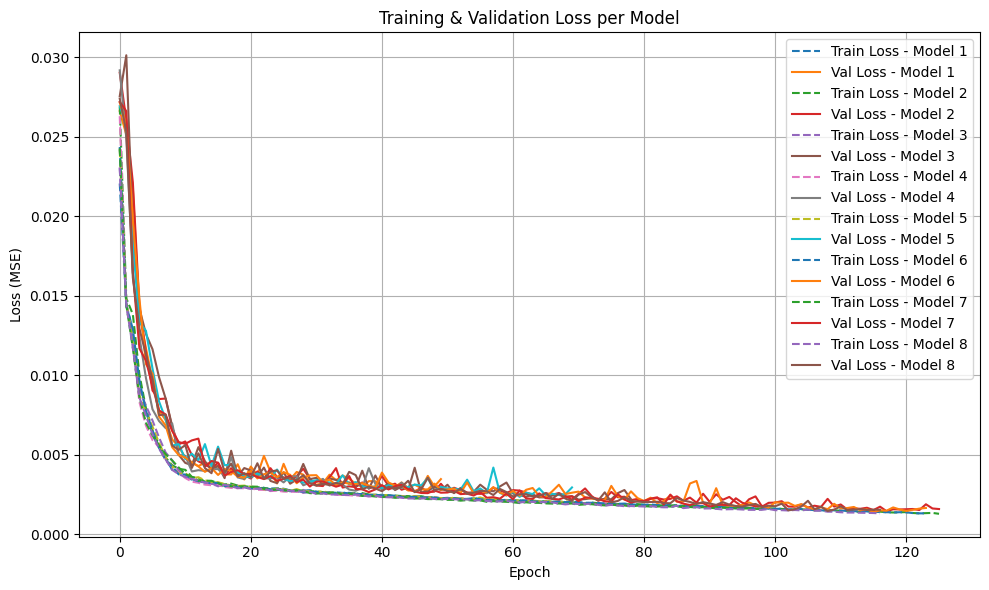

In [48]:
plt.figure(figsize=(10, 6))
for i, history in enumerate(loss_history_all):
    plt.plot(history["train"], label=f"Train Loss - Model {i+1}", linestyle="--")
    plt.plot(history["val"], label=f"Val Loss - Model {i+1}")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.title("Training & Validation Loss per Model")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Predictions

(對 ensemble models 去頭去尾)

In [49]:
# padding window_size - 1 for complete 480 hr
padding = train_scaled[-(window_size - 1):]
combined_scaled = np.concatenate([padding, test_scaled], axis=0)

X_test = []
for i in range(len(combined_scaled) - window_size + 1):
    X_test.append(combined_scaled[i:i + window_size])
X_test = np.array(X_test)

# prediction: use average of ensemble models
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)

with torch.no_grad():
    ensemble_preds = []
    for model in ensemble_models:
        model.eval()
        output = model(X_test_tensor).cpu().numpy()  # shape: (480, 1)
        ensemble_preds.append(output)
    
    # averaging all model prediction results
    # y_pred_scaled = np.mean(ensemble_preds, axis=0)
    ensemble_preds = np.squeeze(np.array(ensemble_preds), axis=2)  # (8, N)
    sorted_preds = np.sort(ensemble_preds, axis=0)   # 排序每個時間點的預測值
    trimmed_mean = np.mean(sorted_preds[1:-1, :], axis=0)  # 去掉最大與最小後取平均
    y_pred_scaled = trimmed_mean.reshape(-1, 1)  # 還原為 (N, 1) 方便後續處理

# restore actual value
y_pred = target_scaler.inverse_transform(y_pred_scaled)

# Corresponds to the correct time
test_index = test_df.index
prediction_df = pd.DataFrame({'datetime': test_index, 'cnt': y_pred.flatten()})

# Convert to daily total
prediction_df["date"] = prediction_df["datetime"].dt.date
daily_predictions = prediction_df.groupby("date")["cnt"].sum().reset_index(drop=True)
daily_predictions.index.name = "id"
daily_predictions = daily_predictions.reset_index()

# output
daily_predictions.to_csv("submission_ensemble.csv", index=False)

In [50]:
# Bagging ensemble: Prediction of val set
with torch.no_grad():
    val_preds = []
    for model in ensemble_models:
        model.eval()
        pred = model(X_val_tensor).cpu().numpy()  # shape: (n_val, 1)
        val_preds.append(pred)

    # averaging all models' predictions
    y_val_pred_scaled = np.mean(val_preds, axis=0)

# restore actual value
y_val_pred = target_scaler.inverse_transform(y_val_pred_scaled)
y_val_true = target_scaler.inverse_transform(y_val)

# Evaluation indicators
mae = mean_absolute_error(y_val_true, y_val_pred)
mse = mean_squared_error(y_val_true, y_val_pred)
r2 = r2_score(y_val_true, y_val_pred)

print(f"Ensemble Validation Results:")
print(f"MAE:  {mae:.2f}")
print(f"MSE:  {mse:.2f}")
print(f"R²:   {r2:.4f}")

Ensemble Validation Results:
MAE:  26.55
MSE:  1481.76
R²:   0.9721


視覺化驗證集的預測結果與真實值對比

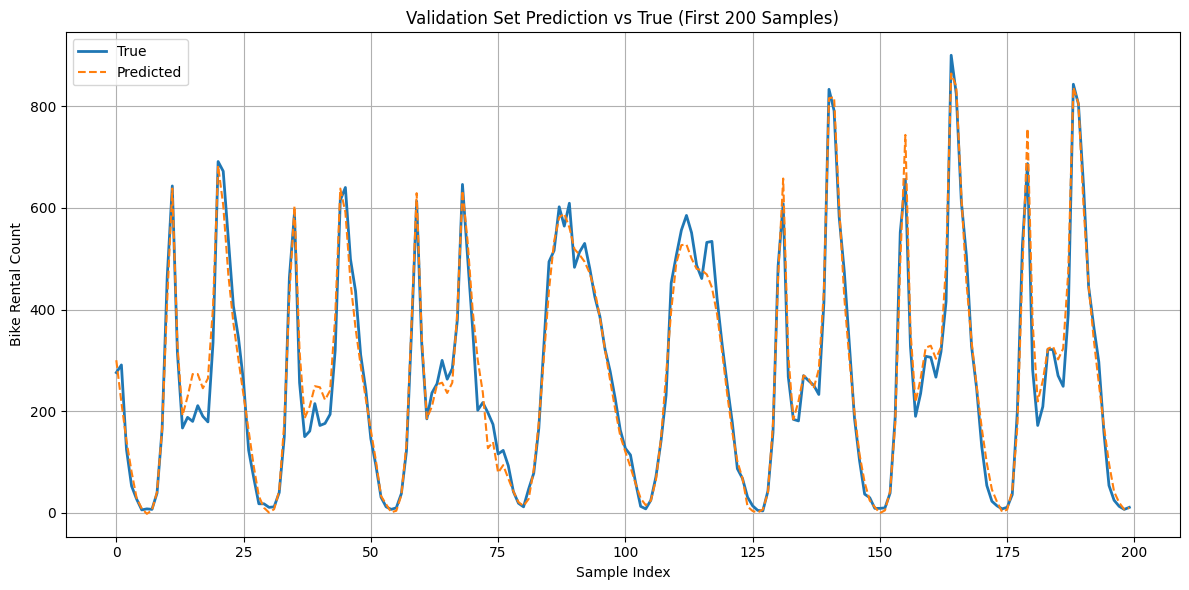

In [51]:
N = 200
plt.figure(figsize=(12, 6))
plt.plot(y_val_true[:N], label="True", linewidth=2)
plt.plot(y_val_pred[:N], label="Predicted", linestyle='--')
plt.title(f"Validation Set Prediction vs True (First {N} Samples)")
plt.xlabel("Sample Index")
plt.ylabel("Bike Rental Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

SHAP (use all features)

/home/anywhere2080ti/miniconda3/lib/python3.13/site-packages/shap/explainers/_deep/deep_pytorch.py:255: UserWarning: unrecognized nn.Module: LSTM
  warnings.warn(f"unrecognized nn.Module: {module_type}")


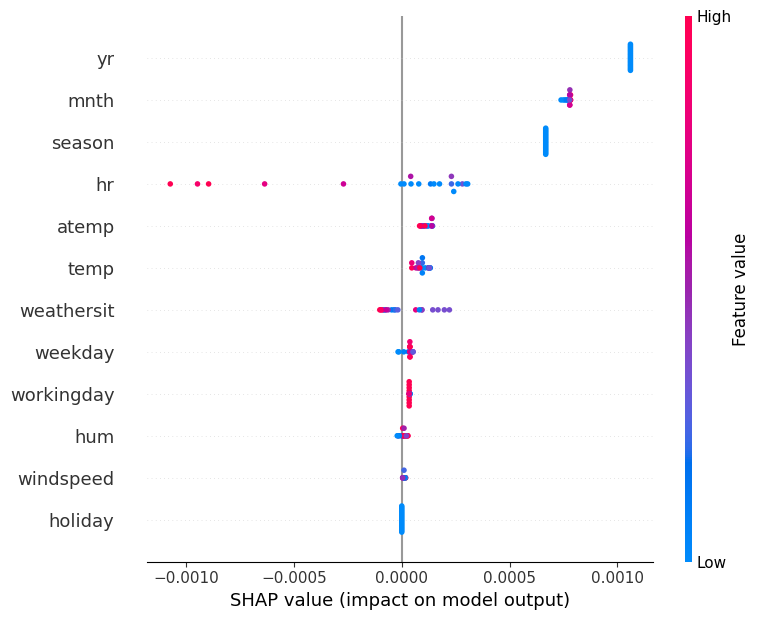

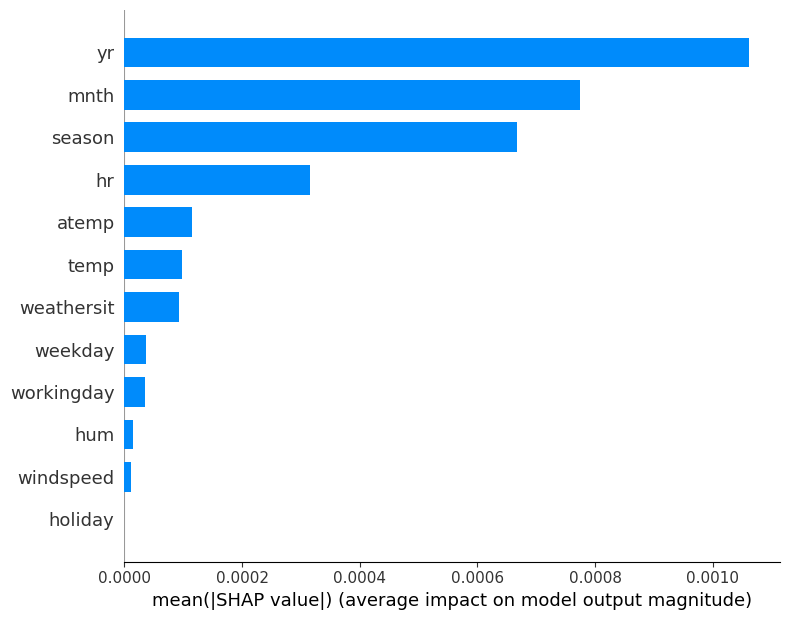

In [19]:
import shap
shap.initjs()
torch.backends.cudnn.enabled = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.train()

# 使用 Deep SHAP 解釋模型
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)

explainer = shap.DeepExplainer(model, X_train_tensor[:50])
X_small = X_test_tensor[:20]

# 拆 batch 解釋（每次 1 筆）
shap_values = []
for i in range(X_small.shape[0]):
    x = X_small[i:i+1]
    shap_val = explainer.shap_values(x, check_additivity=False)  # shap_val[0]: (24, 7, 1)
    
    # ➜ squeeze 掉最後一維 (1)，再對 time_steps (axis=0) 平均
    shap_avg = shap_val[0].squeeze(-1).mean(axis=0)  # shape: (7,)
    shap_values.append(shap_avg)

shap_values_avg = np.stack(shap_values, axis=0)  # shape: (20, 7)
X_small_avg = X_small.cpu().numpy().mean(axis=1)  # shape: (20, 7)

shap.summary_plot(
    shap_values_avg,
    X_small_avg,
    feature_names=['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed']
)

shap.summary_plot(
    shap_values_avg,
    X_small_avg,
    plot_type="bar",
    feature_names=['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed']
)

In [20]:
print("shap_values_avg.shape =", shap_values_avg.shape)
print("X_small_avg.shape =", X_small_avg.shape)
print("shap_val[0].shape:", shap_val[0].shape)

shap_values_avg.shape = (20, 12)
X_small_avg.shape = (20, 12)
shap_val[0].shape: (48, 12, 1)
